### Importing libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [87]:
# Set parameters for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

### Reading the cleaned Data

In [88]:
df = pd.read_excel("MonthWiseMarketArrivals_ChennaiClean.xlsx")
df.head()

market     month  year  quantity  priceMin  priceMax  priceMod       date
0  CHENNAI   January  2004    103400       798      1019       910 2004-01-01
1  CHENNAI  February  2004     87800       776       969       873 2004-02-01
2  CHENNAI     March  2004    102180       506       656       580 2004-03-01
3  CHENNAI     April  2004     83300       448       599       527 2004-04-01
4  CHENNAI       May  2004     84850       462       596       529 2004-05-01

In [89]:
# change the date column to time interval column
df.date = pd.DatetimeIndex(df.date)

In [90]:
# change the index to date column
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")
df.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                       
2004-01  CHENNAI   January  2004    103400       798      1019       910   
2004-02  CHENNAI  February  2004     87800       776       969       873   
2004-03  CHENNAI     March  2004    102180       506       656       580   
2004-04  CHENNAI     April  2004     83300       448       599       527   
2004-05  CHENNAI       May  2004     84850       462       596       529   

              date  
date                
2004-01 2004-01-01  
2004-02 2004-02-01  
2004-03 2004-03-01  
2004-04 2004-04-01  
2004-05 2004-05-01

### Neglecting unimportant variables

In [91]:
df = df.drop(["market","month","year","priceMin","priceMax"], axis=1)
df.tail()

quantity  priceMod       date
date                                  
2020-08     92024      1155 2020-08-01
2020-09     91436      1950 2020-09-01
2020-10     90849      3420 2020-10-01
2020-11     90262      3200 2020-11-01
2020-12     89675      3060 2020-12-01

### Date vs Price

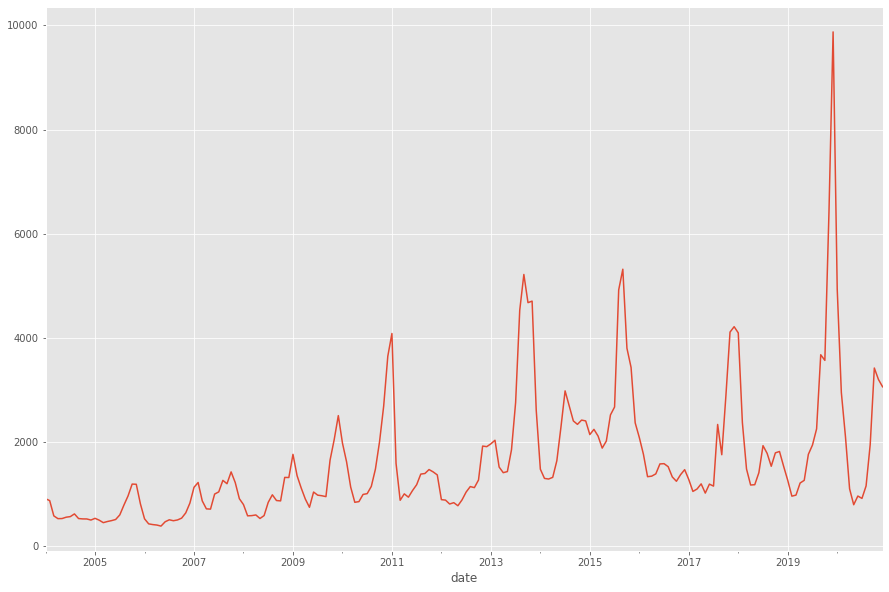

In [92]:
df.priceMod.plot()
plt.show()

### Date vs Quantity

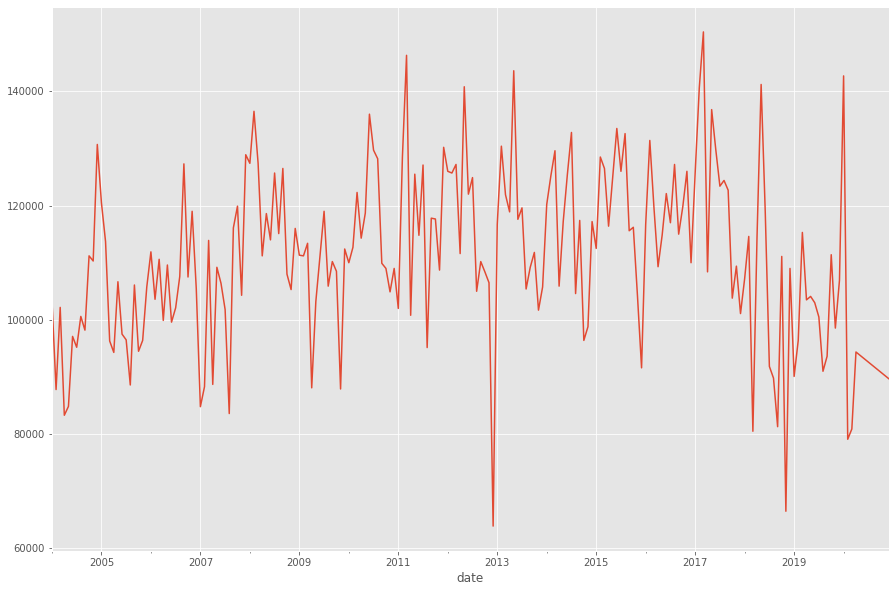

In [93]:
df.quantity.plot()
plt.show()

### Price distribution

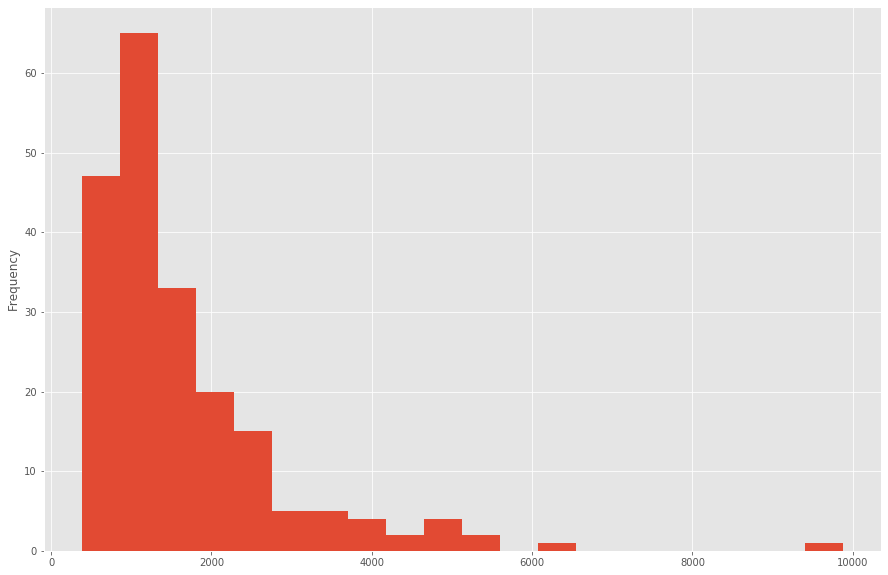

In [94]:
df.priceMod.plot(kind="hist", bins=20)

### Logged Price

Log-transformations can help to stabilize the variance of a time series. Let see using an example:

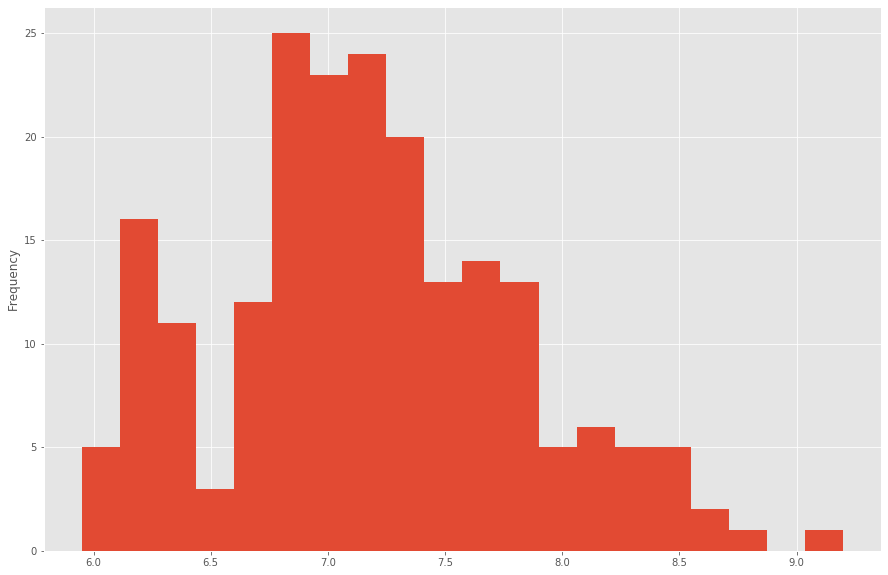

In [95]:
df["log_priceMod"] = np.log(df.priceMod)
df.log_priceMod.plot(kind="hist", bins=20)

The above histogram is more look like normal distribution

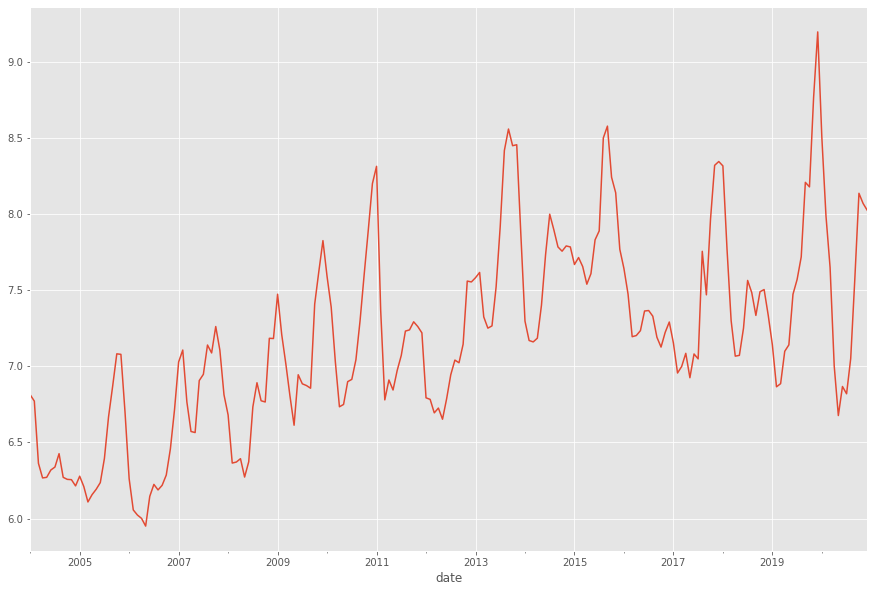

In [96]:
df.log_priceMod.plot()

### Basic Time Series Model

We will build a time-series forecasting model to get a forecast for Onion prices. Let us start with the three most basic models -

1. Mean Constant Model
2. Linear Trend Model
3. Random Walk Model

### 1. Mean Constant Model

In [97]:
df_mean = df.log_priceMod.mean()
df["mean_price"] = np.exp(df_mean)
df.head()

quantity  priceMod       date  log_priceMod  mean_price
date                                                            
2004-01    103400       910 2004-01-01      6.813445  1312.94077
2004-02     87800       873 2004-02-01      6.771936  1312.94077
2004-03    102180       580 2004-03-01      6.363028  1312.94077
2004-04     83300       527 2004-04-01      6.267201  1312.94077
2004-05     84850       529 2004-05-01      6.270988  1312.94077

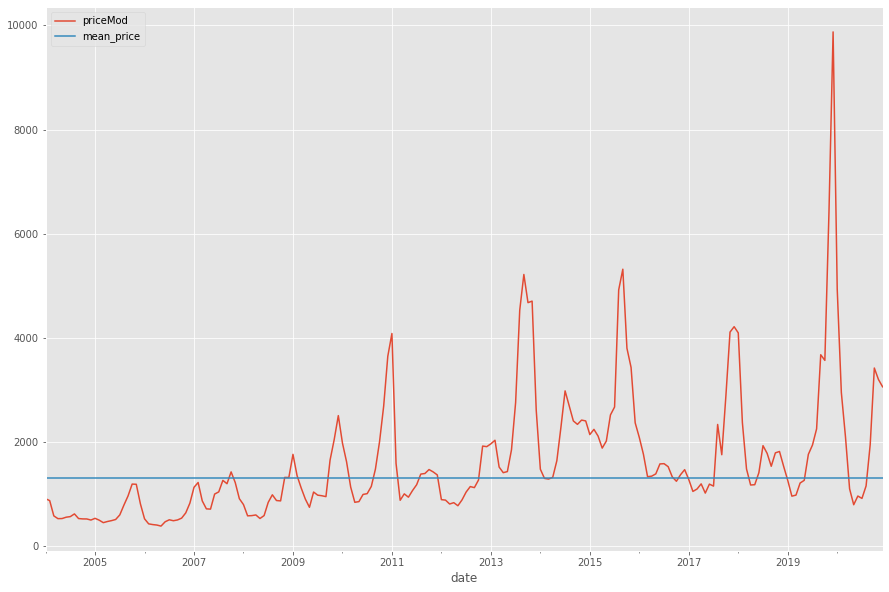

In [98]:
df.plot(kind="line", x="date", y=["priceMod", "mean_price"])

### Evaluate this model using RSME

In [99]:
def RMSE(actual, predicted):
    mse = (actual - predicted)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [100]:
mean_modelRMSE = RMSE(df.priceMod, df.mean_price)
mean_modelRMSE

1271.6884180325062

In [101]:
Result_df = pd.DataFrame(columns =["Model","Actual","Forcast","RMSE"])
Result_df.loc[0,"Model"] = "Mean Model"
Result_df.loc[0,"Actual"] = "3060"
Result_df.loc[0,"Forcast"] = np.exp(df_mean)
Result_df.loc[0,"RMSE"] = mean_modelRMSE
Result_df

Model Actual  Forcast     RMSE
0  Mean Model   3060  1312.94  1271.69

### 2. Linear Trend Model

Let us start by plotting a linear trend model between log_priceMod and time.

However to do linear regression, we need a numeric indicator for time period - Let us create that

In [102]:
df.head()

quantity  priceMod       date  log_priceMod  mean_price
date                                                            
2004-01    103400       910 2004-01-01      6.813445  1312.94077
2004-02     87800       873 2004-02-01      6.771936  1312.94077
2004-03    102180       580 2004-03-01      6.363028  1312.94077
2004-04     83300       527 2004-04-01      6.267201  1312.94077
2004-05     84850       529 2004-05-01      6.270988  1312.94077

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 204 entries, 2004-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   quantity      204 non-null    int64         
 1   priceMod      204 non-null    int64         
 2   date          204 non-null    datetime64[ns]
 3   log_priceMod  204 non-null    float64       
 4   mean_price    204 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.6 KB


In [104]:
# Converting the date into datetinme delta starting from 0
df["timeindex"] = df.date - df.date.min()
df.head()

quantity  priceMod       date  log_priceMod  mean_price timeindex
date                                                                      
2004-01    103400       910 2004-01-01      6.813445  1312.94077    0 days
2004-02     87800       873 2004-02-01      6.771936  1312.94077   31 days
2004-03    102180       580 2004-03-01      6.363028  1312.94077   60 days
2004-04     83300       527 2004-04-01      6.267201  1312.94077   91 days
2004-05     84850       529 2004-05-01      6.270988  1312.94077  121 days

In [105]:
df.dtypes

quantity                  int64
priceMod                  int64
date             datetime64[ns]
log_priceMod            float64
mean_price              float64
timeindex       timedelta64[ns]
dtype: object

In [106]:
# converting the timeindex into months using timedelta
df["timeindex"] = df["timeindex"]/np.timedelta64(1,"M")
df.head()

quantity  priceMod       date  log_priceMod  mean_price  timeindex
date                                                                       
2004-01    103400       910 2004-01-01      6.813445  1312.94077   0.000000
2004-02     87800       873 2004-02-01      6.771936  1312.94077   1.018501
2004-03    102180       580 2004-03-01      6.363028  1312.94077   1.971293
2004-04     83300       527 2004-04-01      6.267201  1312.94077   2.989794
2004-05     84850       529 2004-05-01      6.270988  1312.94077   3.975441

In [107]:
df["timeindex"] = df["timeindex"].round(0).astype(int)
df.tail()

quantity  priceMod       date  log_priceMod  mean_price  timeindex
date                                                                       
2020-08     92024      1155 2020-08-01      7.051856  1312.94077        199
2020-09     91436      1950 2020-09-01      7.575585  1312.94077        200
2020-10     90849      3420 2020-10-01      8.137396  1312.94077        201
2020-11     90262      3200 2020-11-01      8.070906  1312.94077        202
2020-12     89675      3060 2020-12-01      8.026170  1312.94077        203

### Apply the linear model

In [108]:
linear_model = smf.ols('log_priceMod ~ timeindex', data = df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_priceMod   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           1.50e-26
Time:                        16:55:15   Log-Likelihood:                -137.36
No. Observations:                 204   AIC:                             278.7
Df Residuals:                     202   BIC:                             285.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4679      0.067     97.232      0.000       6.337       6.599
timeindex      0.0070      0.001     12.376      0.000       0.006       0.008
==============================================================================
Omnibus:                        9.357   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.379
Skew:                           0.512   Prob(JB):                      0.00919
Kurtosis:                       3.232   Cond. No.                         234.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
linear_model_pred = linear_model.predict()
linear_model_pred

array([6.46792105, 6.47493685, 6.48195265, 6.48896845, 6.49598425,
       6.50300005, 6.51001585, 6.51703165, 6.52404745, 6.53106325,
       6.53807905, 6.54509485, 6.55211065, 6.55912645, 6.56614225,
       6.57315805, 6.58017385, 6.58718965, 6.59420545, 6.60122125,
       6.60823705, 6.61525285, 6.62226865, 6.62928445, 6.63630025,
       6.64331605, 6.65033185, 6.65734765, 6.66436345, 6.67137925,
       6.67839505, 6.68541085, 6.69242665, 6.69944245, 6.70645825,
       6.71347405, 6.72048985, 6.72750565, 6.73452145, 6.74153725,
       6.74855305, 6.75556885, 6.76258465, 6.76960045, 6.77661625,
       6.78363205, 6.79064785, 6.79766365, 6.80467945, 6.81169525,
       6.81871105, 6.82572685, 6.83274265, 6.83975845, 6.84677425,
       6.85379005, 6.86080585, 6.86782166, 6.87483746, 6.88185326,
       6.88886906, 6.89588486, 6.90290066, 6.90991646, 6.91693226,
       6.92394806, 6.93096386, 6.93797966, 6.94499546, 6.95201126,
       6.95902706, 6.96604286, 6.97305866, 6.98007446, 6.98709

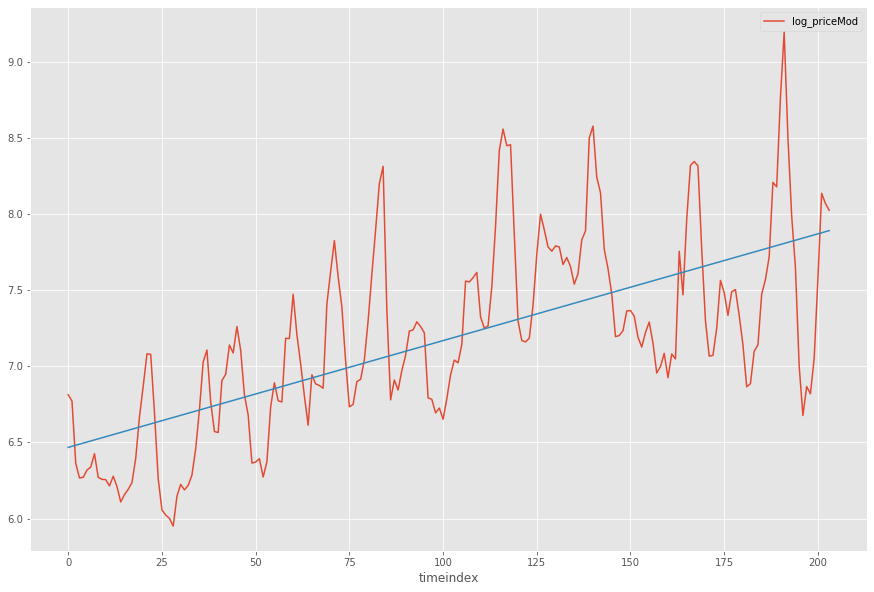

In [110]:
df.plot(kind = "line", x="timeindex", y="log_priceMod")
plt.plot(df.timeindex, linear_model_pred)

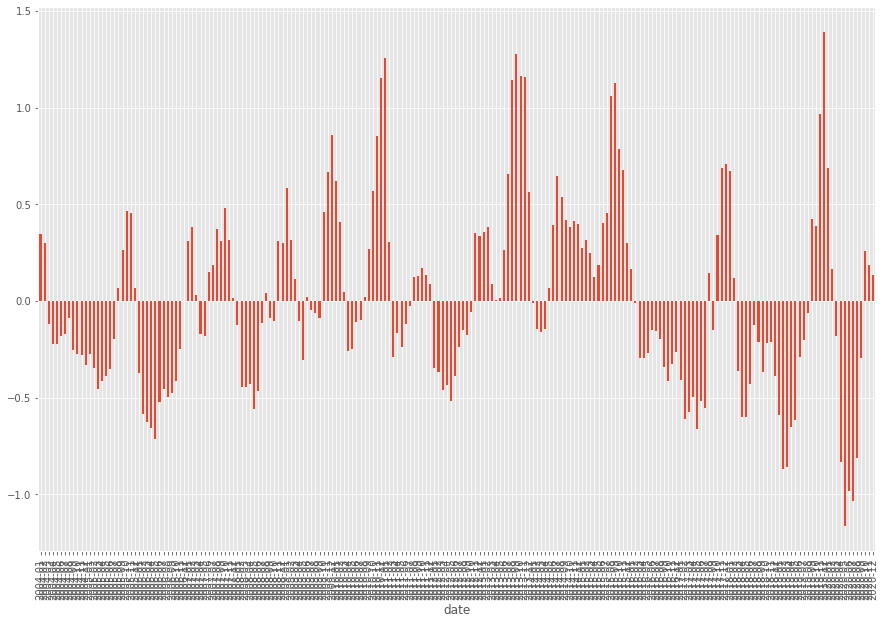

In [111]:
linear_model.resid.plot(kind="bar")

What measures can we check to see if the model is good?

It is seen here (and also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. This tendency is measured in statistical terms by the lag-1 autocorrelation and Durbin-Watson statistic. If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here. If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.

1. Durbin Watson statistic is a test for autocorrelation in a data set.
2. The DW statistic always has a value between zero and 4.0.
3. A value of 2.0 means there is no autocorrelation detected in the sample. Values from zero to 2.0 indicate positive autocorrelation and values from 2.0 to 4.0 indicate negative autocorrelation

A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today. A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

In [112]:
# Manual Calculation
model_linear_forecast_manual = 0.0077 * 203 + 6.4679
model_linear_forecast_manual

8.031

In [113]:
df["linear_price"] = np.exp(linear_model_pred)
df.head()

quantity  priceMod       date  log_priceMod  mean_price  timeindex  \
date                                                                          
2004-01    103400       910 2004-01-01      6.813445  1312.94077          0   
2004-02     87800       873 2004-02-01      6.771936  1312.94077          1   
2004-03    102180       580 2004-03-01      6.363028  1312.94077          2   
2004-04     83300       527 2004-04-01      6.267201  1312.94077          3   
2004-05     84850       529 2004-05-01      6.270988  1312.94077          4   

         linear_price  
date                   
2004-01    644.143189  
2004-02    648.678259  
2004-03    653.245258  
2004-04    657.844411  
2004-05    662.475944

In [114]:
linear_model_RMSE = RMSE(df.priceMod, df.linear_price)
linear_model_RMSE

1096.569541901011

In [115]:
Result_df.loc[1,"Model"] = "Linear Model"
Result_df.loc[1,"Actual"] = "3060"
Result_df.loc[1,"Forcast"] = np.exp(model_linear_forecast_manual)
Result_df.loc[1,"RMSE"] = linear_model_RMSE
Result_df

Model Actual  Forcast     RMSE
0    Mean Model   3060  1312.94  1271.69
1  Linear Model   3060  3074.81  1096.57

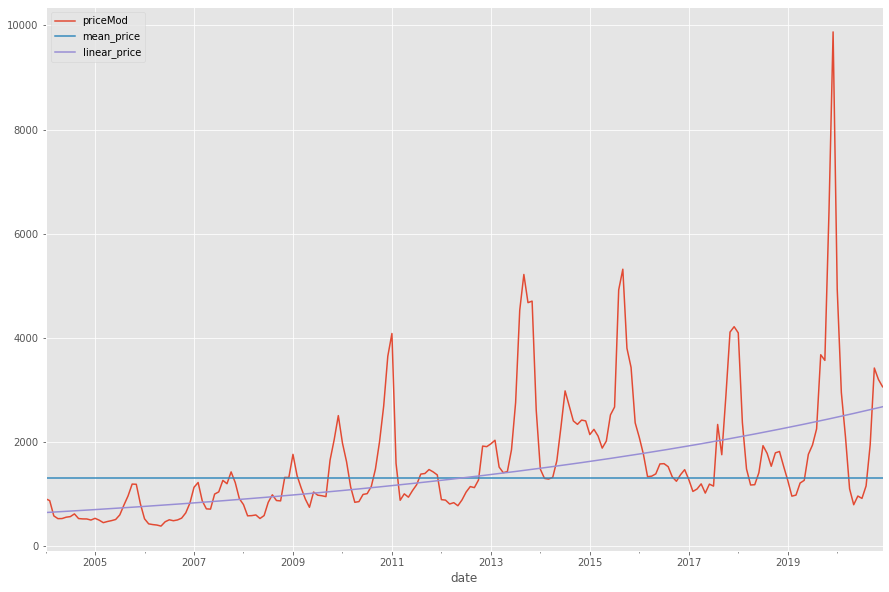

In [116]:
df.plot(kind="line", x="date", y=["priceMod", "mean_price","linear_price"])

In [117]:
linear_model_quant = smf.ols('log_priceMod ~ timeindex + np.log(quantity)', data = df).fit()
linear_model_quant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_priceMod   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     76.32
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           2.19e-25
Time:                        16:55:18   Log-Likelihood:                -137.30
No. Observations:                 204   AIC:                             280.6
Df Residuals:                     201   BIC:                             290.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.4509      2.760      2.699      0.008       2.008      12.894
timeindex            0.0070      0.001     12.350      0.000       0.006       0.008
np.log(quantity)    -0.0847      0.238     -0.356      0.722      -0.554       0.384
==============================================================================
Omnibus:                        9.262   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.250
Skew:                           0.506   Prob(JB):                      0.00980
Kurtosis:                       3.252   Cond. No.                     9.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

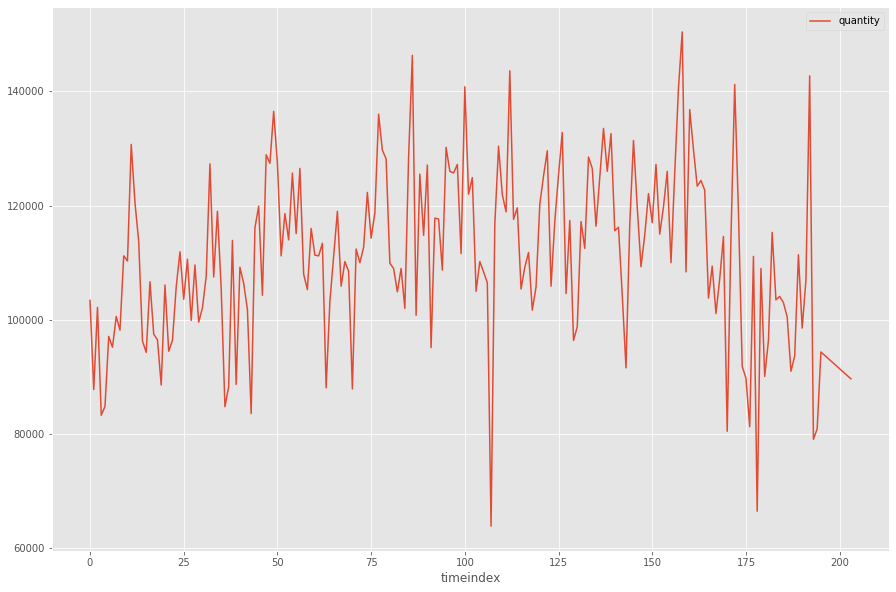

In [118]:
df["linear_price_quant"] = np.exp(linear_model_quant.predict())
df.plot(kind = "line", x="timeindex", y = "quantity")
plt.show()

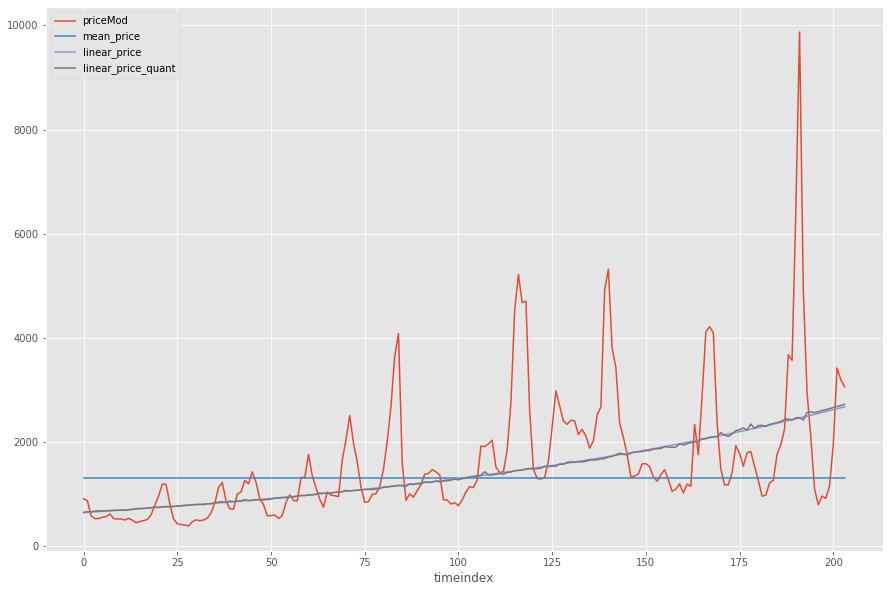

In [119]:
df.plot(kind="line", x="timeindex", y = ["priceMod", "mean_price", 
                                             "linear_price", "linear_price_quant"])
plt.show()

### 3. Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1).

That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.

There are two types of random walks

1. Random walk without drift (no constant or intercept)
2. Random walk with drift (with a constant term)


In [120]:
df["shift_log_priceMod"] = df.log_priceMod.shift()
df.head()

quantity  priceMod       date  log_priceMod  mean_price  timeindex  \
date                                                                          
2004-01    103400       910 2004-01-01      6.813445  1312.94077          0   
2004-02     87800       873 2004-02-01      6.771936  1312.94077          1   
2004-03    102180       580 2004-03-01      6.363028  1312.94077          2   
2004-04     83300       527 2004-04-01      6.267201  1312.94077          3   
2004-05     84850       529 2004-05-01      6.270988  1312.94077          4   

         linear_price  linear_price_quant  shift_log_priceMod  
date                                                           
2004-01    644.143189          647.315296                 NaN  
2004-02    648.678259          660.966294            6.813445  
2004-03    653.245258          657.122843            6.771936  
2004-04    657.844411          673.300428            6.363028  
2004-05    662.475944          676.982876            6.267201

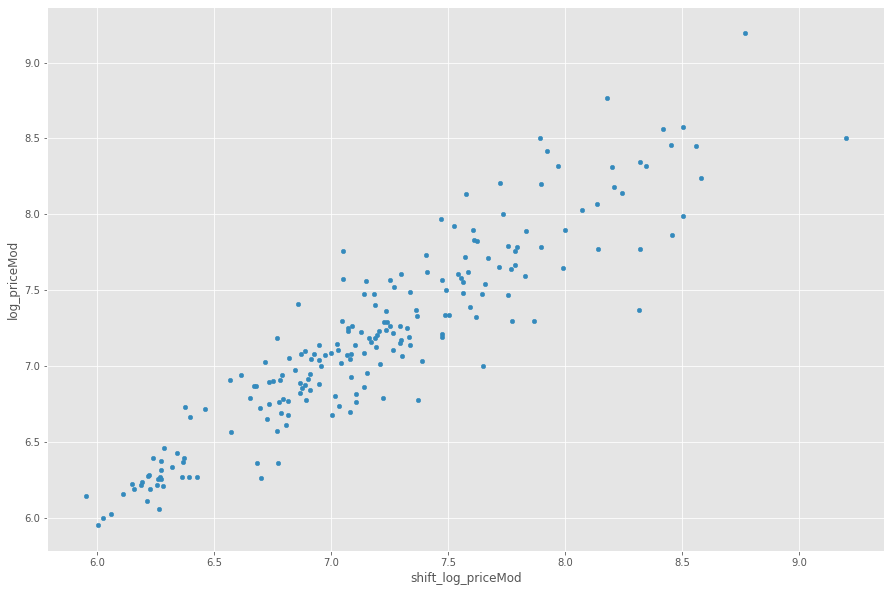

In [121]:
df.plot(kind="scatter", x="shift_log_priceMod", y ="log_priceMod", s=20 )

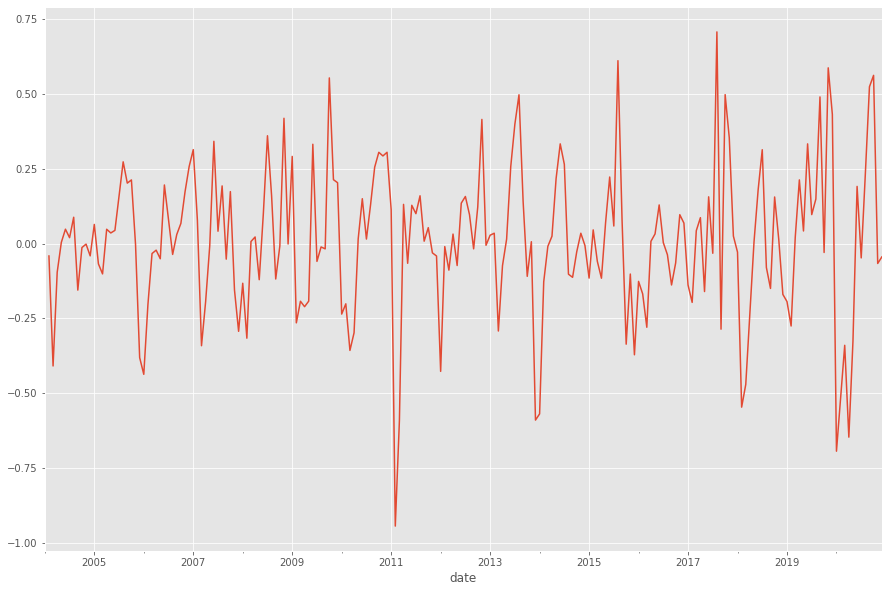

In [122]:
df["log_priceMod_diff"] = df.log_priceMod - df.shift_log_priceMod
df.log_priceMod_diff.plot()

In [123]:
df["random_price"] = np.exp(df.shift_log_priceMod)
df.head()

quantity  priceMod       date  log_priceMod  mean_price  timeindex  \
date                                                                          
2004-01    103400       910 2004-01-01      6.813445  1312.94077          0   
2004-02     87800       873 2004-02-01      6.771936  1312.94077          1   
2004-03    102180       580 2004-03-01      6.363028  1312.94077          2   
2004-04     83300       527 2004-04-01      6.267201  1312.94077          3   
2004-05     84850       529 2004-05-01      6.270988  1312.94077          4   

         linear_price  linear_price_quant  shift_log_priceMod  \
date                                                            
2004-01    644.143189          647.315296                 NaN   
2004-02    648.678259          660.966294            6.813445   
2004-03    653.245258          657.122843            6.771936   
2004-04    657.844411          673.300428            6.363028   
2004-05    662.475944          676.982876            6.267201   

         log_priceMod_diff  random_price  
date                                      
2004-01                NaN           NaN  
2004-02          -0.041509         910.0  
2004-03          -0.408907         873.0  
2004-04          -0.095828         580.0  
2004-05           0.003788         527.0

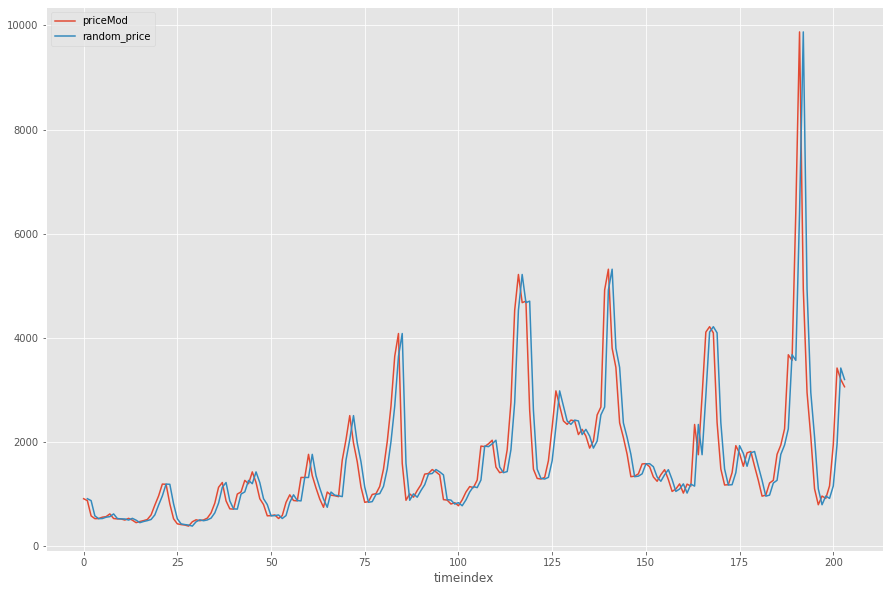

In [124]:
# lets compare random price and actual price
df.plot(kind="line", x="timeindex", y = ["priceMod", "random_price"])

In [125]:
# evaluate the random walk model
random_model_RMSE = RMSE(df.priceMod, df.random_price)
random_model_RMSE

701.6611605586083

In [126]:
Result_df.loc[2,"Model"] = "Random Model"
Result_df.loc[2,"Actual"] = "3060"
Result_df.loc[2,"Forcast"] = np.exp(df.shift_log_priceMod[-1])
Result_df.loc[2,"RMSE"] = random_model_RMSE
Result_df

Model Actual  Forcast     RMSE
0    Mean Model   3060  1312.94  1271.69
1  Linear Model   3060  3074.81  1096.57
2  Random Model   3060     3200  701.661

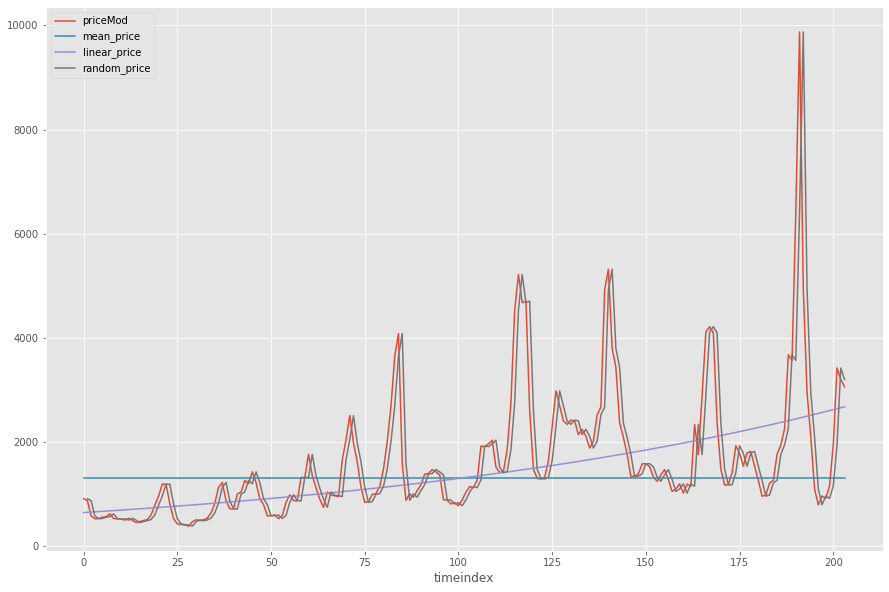

In [127]:
df.plot(kind="line", x="timeindex", y = ["priceMod", "mean_price", "linear_price", "random_price"])